In [2]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import AutoTokenizer, AutoModel

from torch.optim import Adam
from tqdm import tqdm
from torch.nn import BCELoss,NLLLoss,CrossEntropyLoss
from torch.optim.lr_scheduler import StepLR

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [6]:
df = pd.read_csv('final_task1_company.csv', engine='python', on_bad_lines='skip')
df.head()

,text,likes
0,Following is the information about Twitter pos...,1
1,Following is the information about Twitter pos...,2750
2,Following is the information about Twitter pos...,57
3,Following is the information about Twitter pos...,152
4,Following is the information about Twitter pos...,41


In [8]:
#Classifying into 7 buckets
li = []
for i in range(len(df)):
    if(df['likes'][i]<=10):
        li.append(0)
    elif(df['likes'][i]<=100):
        li.append(1)
    elif(df['likes'][i]<=300):
        li.append(2)
    elif(df['likes'][i]<=500):
        li.append(3)
    elif(df['likes'][i]<=1000):
        li.append(4)
    elif(df['likes'][i]<=2500):
        li.append(5)
    else:
        li.append(6)

In [9]:
df['bucket']  = li
df['bucket'] = df['bucket'].astype("object")
df['text'][0]

'Following is the information about Twitter post.Caption for Image of post: a close up of a sandwich and a drink on a table, Text content: Spend your weekend morning with a Ham, Egg, and Cheese Wrap paired with a sweet Iced French Vanilla! ☀️ Order yours now via dine-in, takeout, and delivery. #TimHortonsPH <hyperlink>, Inferred company: tim hortons, Username: TimHortonsPH, Date and time: 2020-12-12 00:47:00, '

In [10]:
df['bucket'].value_counts()

,count
bucket,
0,32364
1,22445
2,18044
4,9192
5,6977
3,5562
6,5417


In [11]:
l = []
for i in range(len(df)):
    if(df['bucket'][i]==6):
        l.append(1)
    else:
        l.append(0)

In [12]:
s = pd.get_dummies(df['bucket'],dtype = np.int32)

In [13]:
df = pd.concat([df,s],axis = 1)

In [14]:
train_df =df[:17000]
val = df[18000:20000]
val = val.reset_index(drop =True)

labels = [0,1,2,3,4,5,6]

In [15]:
def clean(text):
    text = text.replace("<hyperlink>","").replace("<mention>","")
    return text

In [16]:
train_df['text'] = train_df['text'].apply(lambda x:clean(x))
val['text'] = val['text'].apply(lambda x:clean(x))

In [17]:
x_train =train_df.iloc[:,0]
y_train = train_df.iloc[:,1:]
x_test = val.iloc[:,0]
y_test = val.iloc[:,1:]

X_train = pd.DataFrame()
X_train['text'] = x_train
X_test = pd.DataFrame()
X_test['text'] = x_test

In [18]:
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

class Toxic_Dataset(Dataset):
    def __init__(self, Comments_, Labels_):
        self.comments = Comments_.copy()
        self.labels = Labels_.copy()

        self.comments["text"] = self.comments["text"].map(lambda x: tokenizer(x, padding="max_length", truncation=True, return_tensors="pt"))

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
    # Extract tokenized comment
      comment = self.comments.loc[idx, "text"]
    # Get the input_ids and attention_mask
      input_ids = comment['input_ids'].squeeze(0)  # Squeeze to remove the batch dimension
      attention_mask = comment['attention_mask'].squeeze(0)

    # Convert label to tensor and ensure it's 1D
      label = torch.tensor(self.labels.loc[idx, :].argmax(), dtype=torch.long)  # Use argmax to get the class index

      return {"input_ids": input_ids, "attention_mask": attention_mask}, label

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [19]:
# Making Training, Testing and Validation of data using Dataset class
Train_data = Toxic_Dataset(X_train, y_train)
Test_data = Toxic_Dataset(X_test, y_test)
Val_data = Toxic_Dataset(X_test, y_test)

# Making datasets into batches
Train_Loader = DataLoader(Train_data, batch_size=8, shuffle=True)
Test_Loader = DataLoader(Test_data, shuffle=False)
Val_Loader = DataLoader(Val_data, shuffle=False)

In [20]:
Distil_bert = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")

Distil_bert.classifier = nn.Sequential(
    nn.Linear(768, 7),
    nn.Softmax(dim=1)
)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
def train_Model(model,Train_DL, Val_DL, learning_rate, epochs):

    Loss = CrossEntropyLoss()
    #Loss = NLLLoss()
    Optimizer = Adam(params=model.parameters(), lr=learning_rate)
    scheduler = StepLR(Optimizer, step_size=212, gamma=0.1)

    model.to(device)
    model.train()

    train_acc_epochs = []
    train_loss_epochs = []
    val_acc_epochs = []
    val_loss_epochs = []

    for epoch in range(epochs):
        training_loss = {}
        training_accuracy = {}
        validation_loss = {}
        validation_accuracy = {}
        batch = 0

        for comments, labels in tqdm(Train_DL):

            labels = labels.to(device)
            labels = labels.float()
            masks = comments["attention_mask"].squeeze(1).to(device)
            input_ids = comments["input_ids"].squeeze(1).to(device)
            output = model(input_ids, masks)
            #labels = torch.argmax(labels, dim=1)
            #loss = Loss(output.logits, labels)
            k = (output.logits).float()
            loss = Loss(k, labels)

            Optimizer.zero_grad()
            loss.backward()
            Optimizer.step()
            scheduler.step()


            batch += 1
            if batch%10 == 0:
                with torch.no_grad():
                    acc = []
                    op = output.logits
                    for lb in range(len(labels)): # note: labels is of shape (batch_size, num_classes(=7))
                        correct = 0
                        idx = torch.argmax(op[lb])
                        if(labels[lb,idx]==1):
                            correct =1
                        acc.append(correct)

                    training_loss[batch] = loss.item()
                    training_accuracy[batch] = sum(acc)/len(acc)
                    print(f"Epoch:{epoch+1} | batch no:{batch}/{len(Train_DL)} | Loss:{loss.item():.4f} | Accuracy:{sum(acc)/len(acc):.4f}")

                    accVal = []
                    val_loss = 0
                    for comments, label in Val_DL:
                        label = label.to(device)
                        label = label.float()
                        masks = comments["attention_mask"].squeeze(1).to(device)
                        input_ids = comments["input_ids"].squeeze(1).to(device)

                        output = model(input_ids, masks)
                        #label = torch.argmax(label, dim=1)
                        loss = Loss(output.logits, label)

                        val_loss += loss.item()

                        op = output.logits
                        correct_val = 0
                        for lb in range(len(label)): # note: labels is of shape (batch_size, num_classes(=7))
                            correct_val = 0
                            idx = torch.argmax(op[lb])
                            if(label[lb,idx]==1):
                                correct_val =1

                            accVal.append(correct_val)

                    validation_loss[batch] = val_loss/len(Val_DL)
                    validation_accuracy[batch] = sum(accVal)/len(accVal)
                    print(f" Validation Loss:{val_loss/len(Val_DL):.4f} | Validation Accuracy:{sum(accVal)/len(accVal):.4f}")

        train_acc_epochs.append(training_accuracy)
        train_loss_epochs.append(training_loss)
        val_acc_epochs.append(validation_accuracy)
        val_loss_epochs.append(validation_loss)
    torch.save(model.state_dict(), 'model_state_dict.pth')
    return train_acc_epochs, train_loss_epochs, val_acc_epochs, val_loss_epochs

In [22]:
TA, TL, VA, VL = train_Model(Distil_bert, Train_Loader, Val_Loader, learning_rate=0.0001, epochs=1)

  0%|          | 0/2125 [00:01<?, ?it/s]


RuntimeError: "nll_loss_forward_reduce_cuda_kernel_2d_index" not implemented for 'Float'

In [23]:
def train_Model(model, Train_DL, Val_DL, learning_rate, epochs):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    Loss = CrossEntropyLoss()
    Optimizer = Adam(params=model.parameters(), lr=learning_rate)
    scheduler = StepLR(Optimizer, step_size=212, gamma=0.1)

    model.to(device)
    model.train()

    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    for epoch in range(epochs):
        model.train()
        training_loss = 0.0
        training_accuracy = 0.0

        for batch, (comments, labels) in enumerate(tqdm(Train_DL)):
            labels = labels.to(device)
            masks = comments["attention_mask"].squeeze(1).to(device)
            input_ids = comments["input_ids"].squeeze(1).to(device)

            output = model(input_ids, masks)

            if len(labels.shape) > 1:
                labels = torch.argmax(labels, dim=1)

            loss = Loss(output.logits, labels)

            Optimizer.zero_grad()
            loss.backward()
            Optimizer.step()
            scheduler.step()

            training_loss += loss.item()
            predicted_labels = torch.argmax(output.logits, dim=1)
            training_accuracy += (predicted_labels == labels).float().sum().item()

            if (batch + 1) % 10 == 0:
                print(f"Epoch [{epoch+1}/{epochs}], Batch [{batch+1}/{len(Train_DL)}], Loss: {loss.item():.4f}, Accuracy: {training_accuracy / ((batch + 1) * len(labels)):.4f}")

        # Average training metrics
        train_losses.append(training_loss / len(Train_DL))
        train_accuracies.append(training_accuracy / len(Train_DL.dataset))

        # Validation phase
        model.eval()
        with torch.no_grad():
            val_loss = 0.0
            val_accuracy = 0.0
            for comments, label in Val_DL:
                label = label.to(device)
                masks = comments["attention_mask"].squeeze(1).to(device)
                input_ids = comments["input_ids"].squeeze(1).to(device)

                output = model(input_ids, masks)
                if len(label.shape) > 1:
                    label = torch.argmax(label, dim=1)

                val_loss += Loss(output.logits, label).item()
                predicted_labels = torch.argmax(output.logits, dim=1)
                val_accuracy += (predicted_labels == label).float().sum().item()

            val_losses.append(val_loss / len(Val_DL))
            val_accuracies.append(val_accuracy / len(Val_DL.dataset))

            print(f"Validation Loss: {val_loss / len(Val_DL):.4f}, Validation Accuracy: {val_accuracy / len(Val_DL.dataset):.4f}")

    torch.save(model.state_dict(), 'model_state_dict.pth')
    return train_losses, train_accuracies, val_losses, val_accuracies

In [24]:
TL, TA, VL, VA = train_Model(Distil_bert, Train_Loader, Val_Loader, learning_rate=0.0001, epochs=1)

  0%|          | 10/2125 [00:03<11:54,  2.96it/s]

Epoch [1/1], Batch [10/2125], Loss: 1.6775, Accuracy: 0.8000


  1%|          | 20/2125 [00:07<11:37,  3.02it/s]

Epoch [1/1], Batch [20/2125], Loss: 1.4198, Accuracy: 0.8125


  1%|▏         | 30/2125 [00:10<11:39,  3.00it/s]

Epoch [1/1], Batch [30/2125], Loss: 1.2920, Accuracy: 0.8292


  2%|▏         | 40/2125 [00:13<11:35,  3.00it/s]

Epoch [1/1], Batch [40/2125], Loss: 1.5408, Accuracy: 0.8375


  2%|▏         | 50/2125 [00:17<11:32,  3.00it/s]

Epoch [1/1], Batch [50/2125], Loss: 1.2910, Accuracy: 0.8425


  3%|▎         | 60/2125 [00:20<11:29,  2.99it/s]

Epoch [1/1], Batch [60/2125], Loss: 1.1658, Accuracy: 0.8479


  3%|▎         | 70/2125 [00:23<11:31,  2.97it/s]

Epoch [1/1], Batch [70/2125], Loss: 1.4156, Accuracy: 0.8518


  4%|▍         | 80/2125 [00:27<11:25,  2.98it/s]

Epoch [1/1], Batch [80/2125], Loss: 1.4156, Accuracy: 0.8453


  4%|▍         | 90/2125 [00:30<11:25,  2.97it/s]

Epoch [1/1], Batch [90/2125], Loss: 1.2906, Accuracy: 0.8500


  5%|▍         | 100/2125 [00:33<11:22,  2.97it/s]

Epoch [1/1], Batch [100/2125], Loss: 1.2906, Accuracy: 0.8575


  5%|▌         | 110/2125 [00:37<11:24,  2.95it/s]

Epoch [1/1], Batch [110/2125], Loss: 1.2906, Accuracy: 0.8602


  6%|▌         | 120/2125 [00:40<11:19,  2.95it/s]

Epoch [1/1], Batch [120/2125], Loss: 1.2905, Accuracy: 0.8562


  6%|▌         | 130/2125 [00:44<11:18,  2.94it/s]

Epoch [1/1], Batch [130/2125], Loss: 1.5405, Accuracy: 0.8548


  7%|▋         | 140/2125 [00:47<11:20,  2.92it/s]

Epoch [1/1], Batch [140/2125], Loss: 1.4155, Accuracy: 0.8527


  7%|▋         | 150/2125 [00:50<11:12,  2.94it/s]

Epoch [1/1], Batch [150/2125], Loss: 1.1655, Accuracy: 0.8550


  8%|▊         | 160/2125 [00:54<11:13,  2.92it/s]

Epoch [1/1], Batch [160/2125], Loss: 1.1655, Accuracy: 0.8570


  8%|▊         | 170/2125 [00:57<11:09,  2.92it/s]

Epoch [1/1], Batch [170/2125], Loss: 1.5405, Accuracy: 0.8574


  8%|▊         | 180/2125 [01:01<11:21,  2.86it/s]

Epoch [1/1], Batch [180/2125], Loss: 1.2905, Accuracy: 0.8611


  9%|▉         | 190/2125 [01:04<11:06,  2.90it/s]

Epoch [1/1], Batch [190/2125], Loss: 1.4155, Accuracy: 0.8625


  9%|▉         | 200/2125 [01:08<11:02,  2.90it/s]

Epoch [1/1], Batch [200/2125], Loss: 1.4155, Accuracy: 0.8656


 10%|▉         | 210/2125 [01:11<11:00,  2.90it/s]

Epoch [1/1], Batch [210/2125], Loss: 1.2905, Accuracy: 0.8667


 10%|█         | 220/2125 [01:15<10:55,  2.91it/s]

Epoch [1/1], Batch [220/2125], Loss: 1.1655, Accuracy: 0.8682


 11%|█         | 230/2125 [01:18<10:52,  2.91it/s]

Epoch [1/1], Batch [230/2125], Loss: 1.2905, Accuracy: 0.8674


 11%|█▏        | 240/2125 [01:21<10:48,  2.91it/s]

Epoch [1/1], Batch [240/2125], Loss: 1.2905, Accuracy: 0.8667


 12%|█▏        | 250/2125 [01:25<10:51,  2.88it/s]

Epoch [1/1], Batch [250/2125], Loss: 1.1655, Accuracy: 0.8670


 12%|█▏        | 260/2125 [01:28<10:45,  2.89it/s]

Epoch [1/1], Batch [260/2125], Loss: 1.1655, Accuracy: 0.8683


 13%|█▎        | 270/2125 [01:32<10:46,  2.87it/s]

Epoch [1/1], Batch [270/2125], Loss: 1.2905, Accuracy: 0.8676


 13%|█▎        | 280/2125 [01:35<10:44,  2.86it/s]

Epoch [1/1], Batch [280/2125], Loss: 1.5404, Accuracy: 0.8688


 14%|█▎        | 290/2125 [01:39<10:43,  2.85it/s]

Epoch [1/1], Batch [290/2125], Loss: 1.2905, Accuracy: 0.8690


 14%|█▍        | 300/2125 [01:42<10:40,  2.85it/s]

Epoch [1/1], Batch [300/2125], Loss: 1.1655, Accuracy: 0.8683


 15%|█▍        | 310/2125 [01:46<10:35,  2.85it/s]

Epoch [1/1], Batch [310/2125], Loss: 1.2905, Accuracy: 0.8661


 15%|█▌        | 320/2125 [01:49<10:33,  2.85it/s]

Epoch [1/1], Batch [320/2125], Loss: 1.2905, Accuracy: 0.8648


 16%|█▌        | 330/2125 [01:53<10:30,  2.85it/s]

Epoch [1/1], Batch [330/2125], Loss: 1.2905, Accuracy: 0.8644


 16%|█▌        | 340/2125 [01:56<10:27,  2.85it/s]

Epoch [1/1], Batch [340/2125], Loss: 1.1655, Accuracy: 0.8621


 16%|█▋        | 350/2125 [02:00<10:24,  2.84it/s]

Epoch [1/1], Batch [350/2125], Loss: 1.2905, Accuracy: 0.8621


 17%|█▋        | 360/2125 [02:03<10:23,  2.83it/s]

Epoch [1/1], Batch [360/2125], Loss: 1.2905, Accuracy: 0.8615


 17%|█▋        | 370/2125 [02:07<10:17,  2.84it/s]

Epoch [1/1], Batch [370/2125], Loss: 1.1655, Accuracy: 0.8591


 18%|█▊        | 380/2125 [02:11<10:17,  2.83it/s]

Epoch [1/1], Batch [380/2125], Loss: 1.2904, Accuracy: 0.8602


 18%|█▊        | 390/2125 [02:14<10:16,  2.82it/s]

Epoch [1/1], Batch [390/2125], Loss: 1.1655, Accuracy: 0.8612


 19%|█▉        | 400/2125 [02:18<10:09,  2.83it/s]

Epoch [1/1], Batch [400/2125], Loss: 1.4154, Accuracy: 0.8594


 19%|█▉        | 410/2125 [02:21<10:06,  2.83it/s]

Epoch [1/1], Batch [410/2125], Loss: 1.5404, Accuracy: 0.8591


 20%|█▉        | 420/2125 [02:25<10:03,  2.83it/s]

Epoch [1/1], Batch [420/2125], Loss: 1.5404, Accuracy: 0.8565


 20%|██        | 430/2125 [02:28<10:05,  2.80it/s]

Epoch [1/1], Batch [430/2125], Loss: 1.4154, Accuracy: 0.8581


 21%|██        | 440/2125 [02:32<09:59,  2.81it/s]

Epoch [1/1], Batch [440/2125], Loss: 1.1655, Accuracy: 0.8591


 21%|██        | 450/2125 [02:35<09:59,  2.80it/s]

Epoch [1/1], Batch [450/2125], Loss: 1.2905, Accuracy: 0.8600


 22%|██▏       | 460/2125 [02:39<09:52,  2.81it/s]

Epoch [1/1], Batch [460/2125], Loss: 1.2905, Accuracy: 0.8595


 22%|██▏       | 470/2125 [02:42<09:50,  2.80it/s]

Epoch [1/1], Batch [470/2125], Loss: 1.1655, Accuracy: 0.8593


 23%|██▎       | 480/2125 [02:46<09:45,  2.81it/s]

Epoch [1/1], Batch [480/2125], Loss: 1.2905, Accuracy: 0.8594


 23%|██▎       | 490/2125 [02:50<09:44,  2.80it/s]

Epoch [1/1], Batch [490/2125], Loss: 1.4154, Accuracy: 0.8589


 24%|██▎       | 500/2125 [02:53<09:39,  2.80it/s]

Epoch [1/1], Batch [500/2125], Loss: 1.2904, Accuracy: 0.8582


 24%|██▍       | 510/2125 [02:57<09:39,  2.79it/s]

Epoch [1/1], Batch [510/2125], Loss: 1.2904, Accuracy: 0.8578


 24%|██▍       | 520/2125 [03:00<09:32,  2.80it/s]

Epoch [1/1], Batch [520/2125], Loss: 1.2905, Accuracy: 0.8584


 25%|██▍       | 530/2125 [03:04<09:33,  2.78it/s]

Epoch [1/1], Batch [530/2125], Loss: 1.2905, Accuracy: 0.8580


 25%|██▌       | 540/2125 [03:08<09:29,  2.78it/s]

Epoch [1/1], Batch [540/2125], Loss: 1.2905, Accuracy: 0.8588


 26%|██▌       | 550/2125 [03:11<09:25,  2.78it/s]

Epoch [1/1], Batch [550/2125], Loss: 1.1655, Accuracy: 0.8591


 26%|██▋       | 560/2125 [03:15<09:20,  2.79it/s]

Epoch [1/1], Batch [560/2125], Loss: 1.2904, Accuracy: 0.8585


 27%|██▋       | 570/2125 [03:18<09:20,  2.78it/s]

Epoch [1/1], Batch [570/2125], Loss: 1.1655, Accuracy: 0.8592


 27%|██▋       | 580/2125 [03:22<09:15,  2.78it/s]

Epoch [1/1], Batch [580/2125], Loss: 1.2905, Accuracy: 0.8599


 28%|██▊       | 590/2125 [03:26<09:11,  2.78it/s]

Epoch [1/1], Batch [590/2125], Loss: 1.4154, Accuracy: 0.8602


 28%|██▊       | 600/2125 [03:29<09:12,  2.76it/s]

Epoch [1/1], Batch [600/2125], Loss: 1.2904, Accuracy: 0.8608


 29%|██▊       | 610/2125 [03:33<09:06,  2.77it/s]

Epoch [1/1], Batch [610/2125], Loss: 1.4154, Accuracy: 0.8600


 29%|██▉       | 620/2125 [03:36<09:04,  2.76it/s]

Epoch [1/1], Batch [620/2125], Loss: 1.2905, Accuracy: 0.8599


 30%|██▉       | 630/2125 [03:40<09:01,  2.76it/s]

Epoch [1/1], Batch [630/2125], Loss: 1.1655, Accuracy: 0.8593


 30%|███       | 640/2125 [03:44<08:59,  2.75it/s]

Epoch [1/1], Batch [640/2125], Loss: 1.5404, Accuracy: 0.8596


 31%|███       | 650/2125 [03:47<08:51,  2.78it/s]

Epoch [1/1], Batch [650/2125], Loss: 1.1655, Accuracy: 0.8590


 31%|███       | 660/2125 [03:51<08:50,  2.76it/s]

Epoch [1/1], Batch [660/2125], Loss: 1.2905, Accuracy: 0.8591


 32%|███▏      | 670/2125 [03:55<08:50,  2.74it/s]

Epoch [1/1], Batch [670/2125], Loss: 1.4154, Accuracy: 0.8584


 32%|███▏      | 680/2125 [03:58<08:42,  2.77it/s]

Epoch [1/1], Batch [680/2125], Loss: 1.1655, Accuracy: 0.8597


 32%|███▏      | 690/2125 [04:02<08:41,  2.75it/s]

Epoch [1/1], Batch [690/2125], Loss: 1.2905, Accuracy: 0.8600


 33%|███▎      | 700/2125 [04:05<08:37,  2.76it/s]

Epoch [1/1], Batch [700/2125], Loss: 1.4155, Accuracy: 0.8605


 33%|███▎      | 710/2125 [04:09<08:34,  2.75it/s]

Epoch [1/1], Batch [710/2125], Loss: 1.7904, Accuracy: 0.8597


 34%|███▍      | 720/2125 [04:13<08:30,  2.75it/s]

Epoch [1/1], Batch [720/2125], Loss: 1.2904, Accuracy: 0.8592


 34%|███▍      | 730/2125 [04:16<08:25,  2.76it/s]

Epoch [1/1], Batch [730/2125], Loss: 1.2905, Accuracy: 0.8594


 35%|███▍      | 740/2125 [04:20<08:26,  2.74it/s]

Epoch [1/1], Batch [740/2125], Loss: 1.1655, Accuracy: 0.8596


 35%|███▌      | 750/2125 [04:24<08:20,  2.75it/s]

Epoch [1/1], Batch [750/2125], Loss: 1.4154, Accuracy: 0.8597


 36%|███▌      | 760/2125 [04:27<08:16,  2.75it/s]

Epoch [1/1], Batch [760/2125], Loss: 1.1655, Accuracy: 0.8602


 36%|███▌      | 770/2125 [04:31<08:13,  2.74it/s]

Epoch [1/1], Batch [770/2125], Loss: 1.4154, Accuracy: 0.8601


 37%|███▋      | 780/2125 [04:35<08:09,  2.75it/s]

Epoch [1/1], Batch [780/2125], Loss: 1.1655, Accuracy: 0.8604


 37%|███▋      | 790/2125 [04:38<08:05,  2.75it/s]

Epoch [1/1], Batch [790/2125], Loss: 1.1655, Accuracy: 0.8608


 38%|███▊      | 800/2125 [04:42<08:02,  2.75it/s]

Epoch [1/1], Batch [800/2125], Loss: 1.4154, Accuracy: 0.8606


 38%|███▊      | 810/2125 [04:45<07:59,  2.74it/s]

Epoch [1/1], Batch [810/2125], Loss: 1.2905, Accuracy: 0.8605


 39%|███▊      | 820/2125 [04:49<07:55,  2.74it/s]

Epoch [1/1], Batch [820/2125], Loss: 1.2904, Accuracy: 0.8601


 39%|███▉      | 830/2125 [04:53<07:51,  2.75it/s]

Epoch [1/1], Batch [830/2125], Loss: 1.5404, Accuracy: 0.8596


 40%|███▉      | 840/2125 [04:56<07:48,  2.74it/s]

Epoch [1/1], Batch [840/2125], Loss: 1.1655, Accuracy: 0.8594


 40%|████      | 850/2125 [05:00<07:44,  2.74it/s]

Epoch [1/1], Batch [850/2125], Loss: 1.1655, Accuracy: 0.8594


 40%|████      | 860/2125 [05:04<07:40,  2.75it/s]

Epoch [1/1], Batch [860/2125], Loss: 1.1655, Accuracy: 0.8596


 41%|████      | 870/2125 [05:07<07:37,  2.74it/s]

Epoch [1/1], Batch [870/2125], Loss: 1.2905, Accuracy: 0.8602


 41%|████▏     | 880/2125 [05:11<07:34,  2.74it/s]

Epoch [1/1], Batch [880/2125], Loss: 1.2905, Accuracy: 0.8602


 42%|████▏     | 890/2125 [05:15<07:30,  2.74it/s]

Epoch [1/1], Batch [890/2125], Loss: 1.2905, Accuracy: 0.8601


 42%|████▏     | 900/2125 [05:18<07:26,  2.74it/s]

Epoch [1/1], Batch [900/2125], Loss: 1.5404, Accuracy: 0.8599


 43%|████▎     | 910/2125 [05:22<07:22,  2.74it/s]

Epoch [1/1], Batch [910/2125], Loss: 1.2904, Accuracy: 0.8595


 43%|████▎     | 920/2125 [05:26<07:19,  2.74it/s]

Epoch [1/1], Batch [920/2125], Loss: 1.5405, Accuracy: 0.8588


 44%|████▍     | 930/2125 [05:29<07:15,  2.74it/s]

Epoch [1/1], Batch [930/2125], Loss: 1.2904, Accuracy: 0.8591


 44%|████▍     | 940/2125 [05:33<07:13,  2.74it/s]

Epoch [1/1], Batch [940/2125], Loss: 1.4154, Accuracy: 0.8592


 45%|████▍     | 950/2125 [05:37<07:09,  2.73it/s]

Epoch [1/1], Batch [950/2125], Loss: 1.1655, Accuracy: 0.8596


 45%|████▌     | 960/2125 [05:40<07:05,  2.74it/s]

Epoch [1/1], Batch [960/2125], Loss: 1.4154, Accuracy: 0.8591


 46%|████▌     | 970/2125 [05:44<06:59,  2.75it/s]

Epoch [1/1], Batch [970/2125], Loss: 1.4154, Accuracy: 0.8576


 46%|████▌     | 980/2125 [05:47<06:57,  2.74it/s]

Epoch [1/1], Batch [980/2125], Loss: 1.4154, Accuracy: 0.8579


 47%|████▋     | 990/2125 [05:51<06:53,  2.74it/s]

Epoch [1/1], Batch [990/2125], Loss: 1.5404, Accuracy: 0.8578


 47%|████▋     | 1000/2125 [05:55<06:49,  2.75it/s]

Epoch [1/1], Batch [1000/2125], Loss: 1.2905, Accuracy: 0.8574


 48%|████▊     | 1010/2125 [05:58<06:45,  2.75it/s]

Epoch [1/1], Batch [1010/2125], Loss: 1.2905, Accuracy: 0.8571


 48%|████▊     | 1020/2125 [06:02<06:42,  2.75it/s]

Epoch [1/1], Batch [1020/2125], Loss: 1.1655, Accuracy: 0.8566


 48%|████▊     | 1030/2125 [06:06<06:38,  2.74it/s]

Epoch [1/1], Batch [1030/2125], Loss: 1.1655, Accuracy: 0.8564


 49%|████▉     | 1040/2125 [06:09<06:35,  2.74it/s]

Epoch [1/1], Batch [1040/2125], Loss: 1.4154, Accuracy: 0.8570


 49%|████▉     | 1050/2125 [06:13<06:31,  2.74it/s]

Epoch [1/1], Batch [1050/2125], Loss: 1.4155, Accuracy: 0.8568


 50%|████▉     | 1060/2125 [06:17<06:27,  2.75it/s]

Epoch [1/1], Batch [1060/2125], Loss: 1.2905, Accuracy: 0.8568


 50%|█████     | 1070/2125 [06:20<06:24,  2.74it/s]

Epoch [1/1], Batch [1070/2125], Loss: 1.2904, Accuracy: 0.8565


 51%|█████     | 1080/2125 [06:24<06:24,  2.72it/s]

Epoch [1/1], Batch [1080/2125], Loss: 1.2904, Accuracy: 0.8566


 51%|█████▏    | 1090/2125 [06:28<06:18,  2.74it/s]

Epoch [1/1], Batch [1090/2125], Loss: 1.5404, Accuracy: 0.8567


 52%|█████▏    | 1100/2125 [06:31<06:13,  2.74it/s]

Epoch [1/1], Batch [1100/2125], Loss: 1.1655, Accuracy: 0.8560


 52%|█████▏    | 1110/2125 [06:35<06:11,  2.74it/s]

Epoch [1/1], Batch [1110/2125], Loss: 1.2905, Accuracy: 0.8562


 53%|█████▎    | 1120/2125 [06:39<06:06,  2.74it/s]

Epoch [1/1], Batch [1120/2125], Loss: 1.2905, Accuracy: 0.8564


 53%|█████▎    | 1130/2125 [06:42<06:02,  2.74it/s]

Epoch [1/1], Batch [1130/2125], Loss: 1.1655, Accuracy: 0.8561


 54%|█████▎    | 1140/2125 [06:46<05:59,  2.74it/s]

Epoch [1/1], Batch [1140/2125], Loss: 1.2904, Accuracy: 0.8555


 54%|█████▍    | 1150/2125 [06:49<05:58,  2.72it/s]

Epoch [1/1], Batch [1150/2125], Loss: 1.1655, Accuracy: 0.8559


 55%|█████▍    | 1160/2125 [06:53<05:52,  2.74it/s]

Epoch [1/1], Batch [1160/2125], Loss: 1.4154, Accuracy: 0.8559


 55%|█████▌    | 1170/2125 [06:57<05:48,  2.74it/s]

Epoch [1/1], Batch [1170/2125], Loss: 1.1655, Accuracy: 0.8566


 56%|█████▌    | 1180/2125 [07:00<05:48,  2.71it/s]

Epoch [1/1], Batch [1180/2125], Loss: 1.1655, Accuracy: 0.8566


 56%|█████▌    | 1190/2125 [07:04<05:41,  2.74it/s]

Epoch [1/1], Batch [1190/2125], Loss: 1.2905, Accuracy: 0.8569


 56%|█████▋    | 1200/2125 [07:08<05:37,  2.74it/s]

Epoch [1/1], Batch [1200/2125], Loss: 1.1655, Accuracy: 0.8571


 57%|█████▋    | 1210/2125 [07:11<05:34,  2.73it/s]

Epoch [1/1], Batch [1210/2125], Loss: 1.4154, Accuracy: 0.8571


 57%|█████▋    | 1220/2125 [07:15<05:29,  2.75it/s]

Epoch [1/1], Batch [1220/2125], Loss: 1.2905, Accuracy: 0.8569


 58%|█████▊    | 1230/2125 [07:19<05:26,  2.74it/s]

Epoch [1/1], Batch [1230/2125], Loss: 1.2905, Accuracy: 0.8571


 58%|█████▊    | 1240/2125 [07:22<05:22,  2.74it/s]

Epoch [1/1], Batch [1240/2125], Loss: 1.4155, Accuracy: 0.8577


 59%|█████▉    | 1250/2125 [07:26<05:19,  2.74it/s]

Epoch [1/1], Batch [1250/2125], Loss: 1.1655, Accuracy: 0.8578


 59%|█████▉    | 1260/2125 [07:30<05:16,  2.73it/s]

Epoch [1/1], Batch [1260/2125], Loss: 1.2904, Accuracy: 0.8580


 60%|█████▉    | 1270/2125 [07:33<05:12,  2.74it/s]

Epoch [1/1], Batch [1270/2125], Loss: 1.1655, Accuracy: 0.8588


 60%|██████    | 1280/2125 [07:37<05:08,  2.74it/s]

Epoch [1/1], Batch [1280/2125], Loss: 1.4155, Accuracy: 0.8587


 61%|██████    | 1290/2125 [07:41<05:05,  2.73it/s]

Epoch [1/1], Batch [1290/2125], Loss: 1.2905, Accuracy: 0.8587


 61%|██████    | 1300/2125 [07:44<05:01,  2.74it/s]

Epoch [1/1], Batch [1300/2125], Loss: 1.2905, Accuracy: 0.8585


 62%|██████▏   | 1310/2125 [07:48<04:57,  2.74it/s]

Epoch [1/1], Batch [1310/2125], Loss: 1.1655, Accuracy: 0.8588


 62%|██████▏   | 1320/2125 [07:52<04:53,  2.74it/s]

Epoch [1/1], Batch [1320/2125], Loss: 1.4154, Accuracy: 0.8584


 63%|██████▎   | 1330/2125 [07:55<04:49,  2.74it/s]

Epoch [1/1], Batch [1330/2125], Loss: 1.1655, Accuracy: 0.8584


 63%|██████▎   | 1340/2125 [07:59<04:46,  2.74it/s]

Epoch [1/1], Batch [1340/2125], Loss: 1.4154, Accuracy: 0.8583


 64%|██████▎   | 1350/2125 [08:02<04:42,  2.74it/s]

Epoch [1/1], Batch [1350/2125], Loss: 1.5404, Accuracy: 0.8582


 64%|██████▍   | 1360/2125 [08:06<04:38,  2.74it/s]

Epoch [1/1], Batch [1360/2125], Loss: 1.1655, Accuracy: 0.8585


 64%|██████▍   | 1370/2125 [08:10<04:35,  2.74it/s]

Epoch [1/1], Batch [1370/2125], Loss: 1.2905, Accuracy: 0.8589


 65%|██████▍   | 1380/2125 [08:13<04:32,  2.74it/s]

Epoch [1/1], Batch [1380/2125], Loss: 1.4154, Accuracy: 0.8587


 65%|██████▌   | 1390/2125 [08:17<04:28,  2.74it/s]

Epoch [1/1], Batch [1390/2125], Loss: 1.1655, Accuracy: 0.8592


 66%|██████▌   | 1400/2125 [08:21<04:24,  2.74it/s]

Epoch [1/1], Batch [1400/2125], Loss: 1.2904, Accuracy: 0.8596


 66%|██████▋   | 1410/2125 [08:24<04:20,  2.74it/s]

Epoch [1/1], Batch [1410/2125], Loss: 1.1655, Accuracy: 0.8592


 67%|██████▋   | 1420/2125 [08:28<04:17,  2.74it/s]

Epoch [1/1], Batch [1420/2125], Loss: 1.4154, Accuracy: 0.8587


 67%|██████▋   | 1430/2125 [08:32<04:13,  2.74it/s]

Epoch [1/1], Batch [1430/2125], Loss: 1.1655, Accuracy: 0.8588


 68%|██████▊   | 1440/2125 [08:35<04:09,  2.74it/s]

Epoch [1/1], Batch [1440/2125], Loss: 1.2904, Accuracy: 0.8585


 68%|██████▊   | 1450/2125 [08:39<04:06,  2.74it/s]

Epoch [1/1], Batch [1450/2125], Loss: 1.2905, Accuracy: 0.8582


 69%|██████▊   | 1460/2125 [08:43<04:02,  2.74it/s]

Epoch [1/1], Batch [1460/2125], Loss: 1.2905, Accuracy: 0.8578


 69%|██████▉   | 1470/2125 [08:46<03:59,  2.74it/s]

Epoch [1/1], Batch [1470/2125], Loss: 1.2905, Accuracy: 0.8580


 70%|██████▉   | 1480/2125 [08:50<03:55,  2.74it/s]

Epoch [1/1], Batch [1480/2125], Loss: 1.2904, Accuracy: 0.8580


 70%|███████   | 1490/2125 [08:54<03:51,  2.74it/s]

Epoch [1/1], Batch [1490/2125], Loss: 1.6654, Accuracy: 0.8579


 71%|███████   | 1500/2125 [08:57<03:48,  2.74it/s]

Epoch [1/1], Batch [1500/2125], Loss: 1.4154, Accuracy: 0.8575


 71%|███████   | 1510/2125 [09:01<03:45,  2.73it/s]

Epoch [1/1], Batch [1510/2125], Loss: 1.2904, Accuracy: 0.8572


 72%|███████▏  | 1520/2125 [09:05<03:41,  2.73it/s]

Epoch [1/1], Batch [1520/2125], Loss: 1.1655, Accuracy: 0.8571


 72%|███████▏  | 1530/2125 [09:08<03:37,  2.73it/s]

Epoch [1/1], Batch [1530/2125], Loss: 1.1655, Accuracy: 0.8568


 72%|███████▏  | 1540/2125 [09:12<03:33,  2.74it/s]

Epoch [1/1], Batch [1540/2125], Loss: 1.2905, Accuracy: 0.8571


 73%|███████▎  | 1550/2125 [09:16<03:30,  2.73it/s]

Epoch [1/1], Batch [1550/2125], Loss: 1.2905, Accuracy: 0.8570


 73%|███████▎  | 1560/2125 [09:19<03:26,  2.74it/s]

Epoch [1/1], Batch [1560/2125], Loss: 1.1655, Accuracy: 0.8572


 74%|███████▍  | 1570/2125 [09:23<03:22,  2.75it/s]

Epoch [1/1], Batch [1570/2125], Loss: 1.4154, Accuracy: 0.8572


 74%|███████▍  | 1580/2125 [09:26<03:18,  2.74it/s]

Epoch [1/1], Batch [1580/2125], Loss: 1.4155, Accuracy: 0.8571


 75%|███████▍  | 1590/2125 [09:30<03:15,  2.74it/s]

Epoch [1/1], Batch [1590/2125], Loss: 1.1655, Accuracy: 0.8573


 75%|███████▌  | 1600/2125 [09:34<03:11,  2.74it/s]

Epoch [1/1], Batch [1600/2125], Loss: 1.1655, Accuracy: 0.8577


 76%|███████▌  | 1610/2125 [09:37<03:07,  2.74it/s]

Epoch [1/1], Batch [1610/2125], Loss: 1.1655, Accuracy: 0.8579


 76%|███████▌  | 1620/2125 [09:41<03:05,  2.72it/s]

Epoch [1/1], Batch [1620/2125], Loss: 1.1655, Accuracy: 0.8579


 77%|███████▋  | 1630/2125 [09:45<03:00,  2.74it/s]

Epoch [1/1], Batch [1630/2125], Loss: 1.1655, Accuracy: 0.8581


 77%|███████▋  | 1640/2125 [09:48<02:57,  2.74it/s]

Epoch [1/1], Batch [1640/2125], Loss: 1.5404, Accuracy: 0.8579


 78%|███████▊  | 1650/2125 [09:52<02:54,  2.72it/s]

Epoch [1/1], Batch [1650/2125], Loss: 1.2905, Accuracy: 0.8580


 78%|███████▊  | 1660/2125 [09:56<02:49,  2.74it/s]

Epoch [1/1], Batch [1660/2125], Loss: 1.1655, Accuracy: 0.8579


 79%|███████▊  | 1670/2125 [09:59<02:46,  2.74it/s]

Epoch [1/1], Batch [1670/2125], Loss: 1.2904, Accuracy: 0.8579


 79%|███████▉  | 1680/2125 [10:03<02:43,  2.72it/s]

Epoch [1/1], Batch [1680/2125], Loss: 1.1655, Accuracy: 0.8574


 80%|███████▉  | 1690/2125 [10:07<02:39,  2.73it/s]

Epoch [1/1], Batch [1690/2125], Loss: 1.5404, Accuracy: 0.8569


 80%|████████  | 1700/2125 [10:10<02:36,  2.72it/s]

Epoch [1/1], Batch [1700/2125], Loss: 1.2905, Accuracy: 0.8566


 80%|████████  | 1710/2125 [10:14<02:31,  2.73it/s]

Epoch [1/1], Batch [1710/2125], Loss: 1.4154, Accuracy: 0.8566


 81%|████████  | 1720/2125 [10:18<02:27,  2.74it/s]

Epoch [1/1], Batch [1720/2125], Loss: 1.4154, Accuracy: 0.8567


 81%|████████▏ | 1730/2125 [10:21<02:24,  2.74it/s]

Epoch [1/1], Batch [1730/2125], Loss: 1.4155, Accuracy: 0.8567


 82%|████████▏ | 1740/2125 [10:25<02:20,  2.74it/s]

Epoch [1/1], Batch [1740/2125], Loss: 1.1655, Accuracy: 0.8568


 82%|████████▏ | 1750/2125 [10:29<02:18,  2.72it/s]

Epoch [1/1], Batch [1750/2125], Loss: 1.1655, Accuracy: 0.8568


 83%|████████▎ | 1760/2125 [10:32<02:13,  2.74it/s]

Epoch [1/1], Batch [1760/2125], Loss: 1.1655, Accuracy: 0.8568


 83%|████████▎ | 1770/2125 [10:36<02:09,  2.74it/s]

Epoch [1/1], Batch [1770/2125], Loss: 1.2905, Accuracy: 0.8569


 84%|████████▍ | 1780/2125 [10:40<02:05,  2.74it/s]

Epoch [1/1], Batch [1780/2125], Loss: 1.2904, Accuracy: 0.8571


 84%|████████▍ | 1790/2125 [10:43<02:02,  2.74it/s]

Epoch [1/1], Batch [1790/2125], Loss: 1.4154, Accuracy: 0.8569


 85%|████████▍ | 1800/2125 [10:47<01:58,  2.74it/s]

Epoch [1/1], Batch [1800/2125], Loss: 1.1655, Accuracy: 0.8565


 85%|████████▌ | 1810/2125 [10:51<01:55,  2.72it/s]

Epoch [1/1], Batch [1810/2125], Loss: 1.4154, Accuracy: 0.8565


 86%|████████▌ | 1820/2125 [10:54<01:51,  2.73it/s]

Epoch [1/1], Batch [1820/2125], Loss: 1.4155, Accuracy: 0.8561


 86%|████████▌ | 1830/2125 [10:58<01:47,  2.74it/s]

Epoch [1/1], Batch [1830/2125], Loss: 1.1655, Accuracy: 0.8564


 87%|████████▋ | 1840/2125 [11:02<01:43,  2.74it/s]

Epoch [1/1], Batch [1840/2125], Loss: 1.4154, Accuracy: 0.8567


 87%|████████▋ | 1850/2125 [11:05<01:41,  2.72it/s]

Epoch [1/1], Batch [1850/2125], Loss: 1.1655, Accuracy: 0.8570


 88%|████████▊ | 1860/2125 [11:09<01:36,  2.74it/s]

Epoch [1/1], Batch [1860/2125], Loss: 1.2904, Accuracy: 0.8568


 88%|████████▊ | 1870/2125 [11:12<01:33,  2.72it/s]

Epoch [1/1], Batch [1870/2125], Loss: 1.4155, Accuracy: 0.8569


 88%|████████▊ | 1880/2125 [11:16<01:29,  2.74it/s]

Epoch [1/1], Batch [1880/2125], Loss: 1.1655, Accuracy: 0.8566


 89%|████████▉ | 1890/2125 [11:20<01:25,  2.74it/s]

Epoch [1/1], Batch [1890/2125], Loss: 1.5404, Accuracy: 0.8566


 89%|████████▉ | 1900/2125 [11:23<01:22,  2.74it/s]

Epoch [1/1], Batch [1900/2125], Loss: 1.1655, Accuracy: 0.8570


 90%|████████▉ | 1910/2125 [11:27<01:18,  2.74it/s]

Epoch [1/1], Batch [1910/2125], Loss: 1.2905, Accuracy: 0.8569


 90%|█████████ | 1920/2125 [11:31<01:14,  2.74it/s]

Epoch [1/1], Batch [1920/2125], Loss: 1.5404, Accuracy: 0.8569


 91%|█████████ | 1930/2125 [11:34<01:11,  2.74it/s]

Epoch [1/1], Batch [1930/2125], Loss: 1.2905, Accuracy: 0.8570


 91%|█████████▏| 1940/2125 [11:38<01:07,  2.72it/s]

Epoch [1/1], Batch [1940/2125], Loss: 1.1655, Accuracy: 0.8572


 92%|█████████▏| 1950/2125 [11:42<01:04,  2.72it/s]

Epoch [1/1], Batch [1950/2125], Loss: 1.1655, Accuracy: 0.8571


 92%|█████████▏| 1960/2125 [11:45<01:00,  2.74it/s]

Epoch [1/1], Batch [1960/2125], Loss: 1.5404, Accuracy: 0.8571


 93%|█████████▎| 1970/2125 [11:49<00:56,  2.73it/s]

Epoch [1/1], Batch [1970/2125], Loss: 1.5404, Accuracy: 0.8568


 93%|█████████▎| 1980/2125 [11:53<00:53,  2.73it/s]

Epoch [1/1], Batch [1980/2125], Loss: 1.2904, Accuracy: 0.8568


 94%|█████████▎| 1990/2125 [11:56<00:49,  2.72it/s]

Epoch [1/1], Batch [1990/2125], Loss: 1.2905, Accuracy: 0.8568


 94%|█████████▍| 2000/2125 [12:00<00:45,  2.74it/s]

Epoch [1/1], Batch [2000/2125], Loss: 1.4154, Accuracy: 0.8567


 95%|█████████▍| 2010/2125 [12:04<00:42,  2.73it/s]

Epoch [1/1], Batch [2010/2125], Loss: 1.2905, Accuracy: 0.8569


 95%|█████████▌| 2020/2125 [12:07<00:38,  2.72it/s]

Epoch [1/1], Batch [2020/2125], Loss: 1.1655, Accuracy: 0.8573


 96%|█████████▌| 2030/2125 [12:11<00:34,  2.74it/s]

Epoch [1/1], Batch [2030/2125], Loss: 1.2904, Accuracy: 0.8573


 96%|█████████▌| 2040/2125 [12:15<00:31,  2.74it/s]

Epoch [1/1], Batch [2040/2125], Loss: 1.2905, Accuracy: 0.8574


 96%|█████████▋| 2050/2125 [12:18<00:27,  2.72it/s]

Epoch [1/1], Batch [2050/2125], Loss: 1.2905, Accuracy: 0.8574


 97%|█████████▋| 2060/2125 [12:22<00:23,  2.74it/s]

Epoch [1/1], Batch [2060/2125], Loss: 1.2905, Accuracy: 0.8578


 97%|█████████▋| 2070/2125 [12:26<00:20,  2.73it/s]

Epoch [1/1], Batch [2070/2125], Loss: 1.1655, Accuracy: 0.8574


 98%|█████████▊| 2080/2125 [12:29<00:16,  2.74it/s]

Epoch [1/1], Batch [2080/2125], Loss: 1.2904, Accuracy: 0.8575


 98%|█████████▊| 2090/2125 [12:33<00:12,  2.74it/s]

Epoch [1/1], Batch [2090/2125], Loss: 1.5405, Accuracy: 0.8577


 99%|█████████▉| 2100/2125 [12:37<00:09,  2.74it/s]

Epoch [1/1], Batch [2100/2125], Loss: 1.2904, Accuracy: 0.8577


 99%|█████████▉| 2110/2125 [12:40<00:05,  2.73it/s]

Epoch [1/1], Batch [2110/2125], Loss: 1.1655, Accuracy: 0.8579


100%|█████████▉| 2120/2125 [12:44<00:01,  2.72it/s]

Epoch [1/1], Batch [2120/2125], Loss: 1.2904, Accuracy: 0.8575


100%|██████████| 2125/2125 [12:46<00:00,  2.77it/s]


Validation Loss: 1.3169, Validation Accuracy: 0.8485


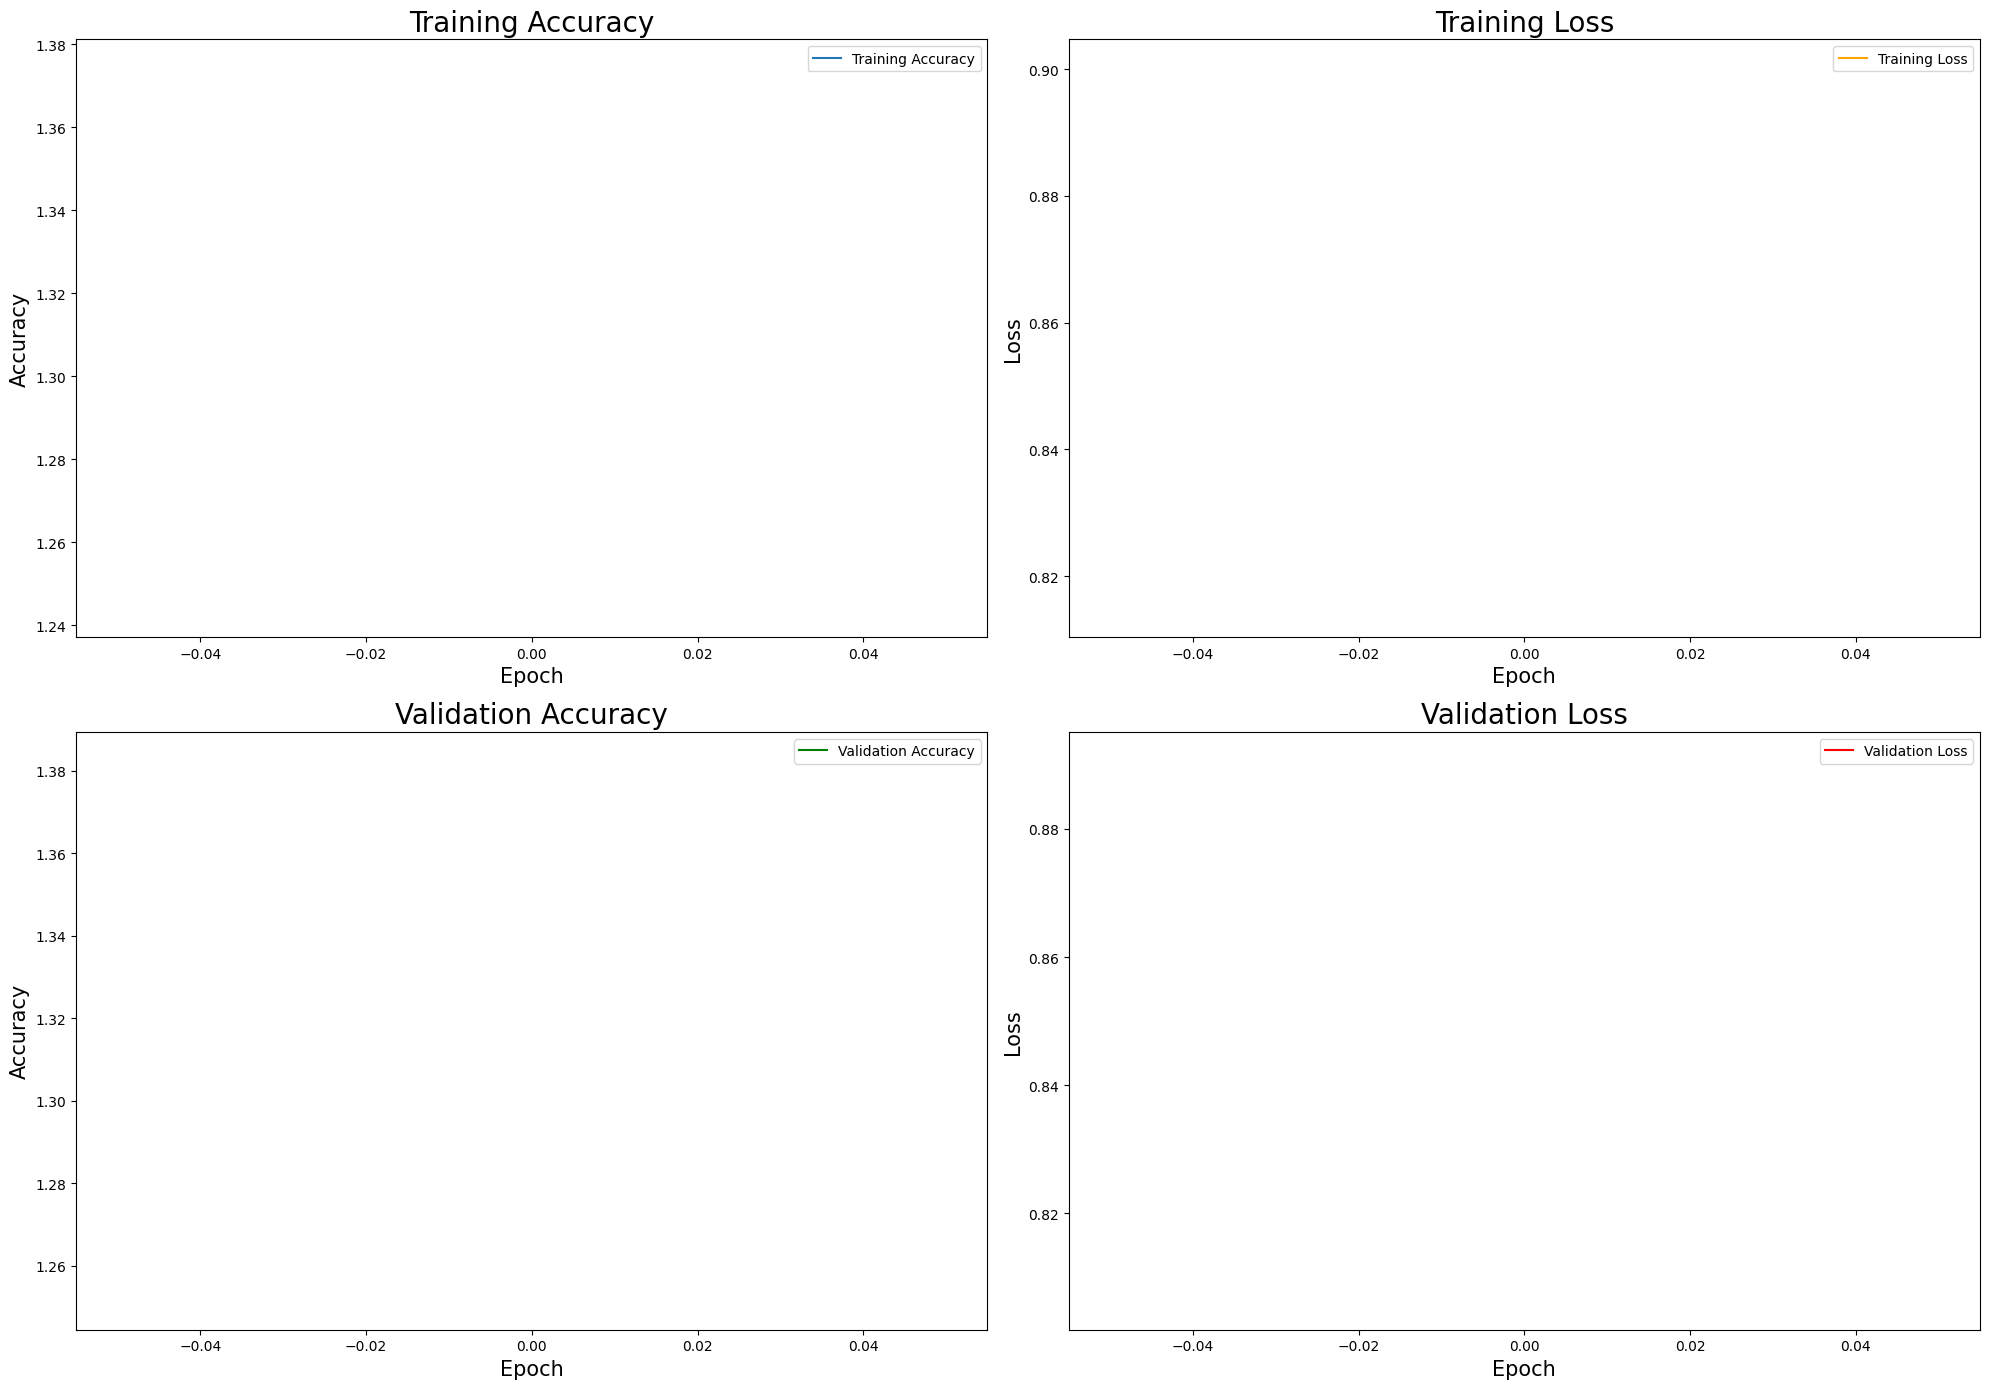

In [25]:
def Acc_Loss_Plot(train_acc, train_loss, val_acc, val_loss):
    plt.figure(figsize=(20, 14))

    # Plot Training Accuracy
    Ac = plt.subplot(2, 2, 1)
    plt.plot(train_acc, label="Training Accuracy")
    Ac.set_xlabel("Epoch", fontsize=15)
    Ac.set_ylabel("Accuracy", fontsize=15)
    Ac.set_title("Training Accuracy", fontsize=20)
    Ac.legend()

    # Plot Training Loss
    Ls = plt.subplot(2, 2, 2)
    plt.plot(train_loss, label="Training Loss", color='orange')
    Ls.set_xlabel("Epoch", fontsize=15)
    Ls.set_ylabel("Loss", fontsize=15)
    Ls.set_title("Training Loss", fontsize=20)
    Ls.legend()

    # Plot Validation Accuracy
    VAc = plt.subplot(2, 2, 3)
    plt.plot(val_acc, label="Validation Accuracy", color='green')
    VAc.set_xlabel("Epoch", fontsize=15)
    VAc.set_ylabel("Accuracy", fontsize=15)
    VAc.set_title("Validation Accuracy", fontsize=20)
    VAc.legend()

    # Plot Validation Loss
    VLs = plt.subplot(2, 2, 4)
    plt.plot(val_loss, label="Validation Loss", color='red')
    VLs.set_xlabel("Epoch", fontsize=15)
    VLs.set_ylabel("Loss", fontsize=15)
    VLs.set_title("Validation Loss", fontsize=20)
    VLs.legend()

    plt.tight_layout()  # Adjusts plot spacing
    plt.show()

# Call the plotting function
Acc_Loss_Plot(TL, TA, VL, VA)

In [26]:
def inference(model, Test_DL):

    # Ensure model is in evaluation mode
    model.eval()
    pred = []
    labels = []
    logs = []

    for comments, label in Test_DL:
        label = label.to(device)
        label = label.float()
        masks = comments["attention_mask"].squeeze(1).to(device)
        input_ids = comments["input_ids"].squeeze(1).to(device)

    # Perform inference
        with torch.no_grad():
            output = model(input_ids, masks)

    # Extract logits and compute the predicted class index
        logits = output.logits
        logs.append(logits)
        pred_class = torch.argmax(logits, dim=1).item()
        pred.append(pred_class)
        labels.append(label)

    return pred, labels, logs

In [33]:
dft1=pd.read_csv('/content/final_task1_company.csv')
evaluate1 = dft1.iloc[:,0]

In [34]:
evaluate1

,text
0,Following is the information about Twitter pos...
1,Following is the information about Twitter pos...
2,Following is the information about Twitter pos...
3,Following is the information about Twitter pos...
4,Following is the information about Twitter pos...
...,...
99996,Following is the information about Twitter pos...
99997,Following is the information about Twitter pos...
99998,Following is the information about Twitter pos...
99999,Following is the information about Twitter pos...


In [35]:
X_test = pd.DataFrame()
X_test['text'] = evaluate1

In [36]:
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

# Creating Dataset class for Toxic comments with no Labels
class TestToxic_Dataset(Dataset):
    def __init__(self, Comments_):
        self.comments = Comments_.copy()
        self.comments["text"] = self.comments["text"].map(lambda x: tokenizer(x, padding="max_length", truncation=True, return_tensors="pt"))

    def __len__(self):
        return len(self.comments)

    def __getitem__(self, idx):
        comment = self.comments.loc[idx, "text"]
        return comment

In [37]:
Test_data = TestToxic_Dataset(X_test)
Test_Loader = DataLoader(Test_data, shuffle=False)

In [38]:
def infer(model, Test_DL):

    # Ensure model is in evaluation mode
    model.eval()
    pred = []
    logs = []

    for comments in Test_DL:
        masks = comments["attention_mask"].squeeze(1).to(device)
        input_ids = comments["input_ids"].squeeze(1).to(device)

        # Perform inference
        with torch.no_grad():
            output = model(input_ids, masks)

        # Extract logits and compute the predicted class index
        logits = output.logits
        logs.append(logits)
        pred_class = torch.argmax(logits, dim=1).item()
        pred.append(pred_class)

    return pred, logs

In [39]:
pred,logs = infer(Distil_bert,Test_Loader)

In [40]:
dft1['bucket']=pred

In [41]:
dft1.to_csv('/content/time_bucket.csv',index=False)

In [42]:
from google.colab import files
files.download("/content/time_bucket.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [46]:
labels[0]

0

In [48]:
gt = []
for i in range(len(labels)):
    if isinstance(labels[i], torch.Tensor):  # Check if it's a tensor
        label = torch.argmax(labels[i], dim=1).item()  # Apply argmax only to tensors
    else:
        label = labels[i]  # If it's already an int, no need for argmax
    gt.append(label)

In [49]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(gt, pred)

# Print the accuracy score
print("Accuracy:", accuracy)

ValueError: Found input variables with inconsistent numbers of samples: [7, 100001]

In [50]:
print("Length of ground truth (gt):", len(gt))
print("Length of predictions (pred):", len(pred))

Length of ground truth (gt): 7
Length of predictions (pred): 100001
